In [1]:
!pip install keras

In [9]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [8]:
! pip install "tensorflow>=1.7.0"
! pip install tensorflow-hub

  Using cached https://files.pythonhosted.org/packages/54/5f/e1b2d83b808f978f51b7ce109315154da3a3d4151aa59686002681f2e109/tensorflow-2.0.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/a8/ae/a11b9b0c8e2410b11887881990b71f54ec39b17c4de2b5d850ef66aade8c/protobuf-3.10.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9b/a6/e8ffa4e2ddb216449d34cfcb825ebb38206bee5c4553d69e7bc8bc2c5d64/tensorboard-2.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c0/4e/fd492e91abdc2d2fcb70ef453064d980688762079397f779758e055f6575/Markdown-3.1.1-py2.py3-none-any.whl


tensorboard 2.0.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.


In [71]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word embeddings

In [72]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


In [73]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [74]:

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [75]:
df = pd.read_csv(r'C:\Users\HPPC\Tweets.csv',encoding = 'utf-8')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [77]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [78]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    13176.000000
mean        11.161658
std          4.215267
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

In [79]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [106]:
X_train_seq_trunc

array([[   0,    0,    0, ..., 2281, 1162, 1572],
       [   0,    0,    0, ..., 2282,  399,   22],
       [   0,    0,    0, ...,  214,   79,  588],
       ...,
       [   0,    0,    0, ...,   89,  218,  179],
       [   0,    0,    0, ...,  770,  497, 5478],
       [   0,    0,    0, ...,   17,  344, 2019]])

In [80]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  214, 1573,
       1163,   45,  648,  831, 1214,  624,  671,    1,  112,   69,  402,
         60,  935])

In [81]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [114]:
y_test_oh[10]

array([1., 0., 0.], dtype=float32)

In [115]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1318, 24)


In [83]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 8)             80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 579       
Total params: 80,579
Trainable params: 80,579
Non-trainable params: 0
_________________________________________________________________


In [84]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 1s 85us/step - loss: 1.0465 - accuracy: 0.5714 - val_loss: 0.9842 - val_accuracy: 0.6404
Epoch 2/20
11858/11858 [==============================] - 1s 44us/step - loss: 0.9439 - accuracy: 0.6234 - val_loss: 0.8945 - val_accuracy: 0.6404
Epoch 3/20
11858/11858 [==============================] - 0s 39us/step - loss: 0.8711 - accuracy: 0.6234 - val_loss: 0.8387 - val_accuracy: 0.6404
Epoch 4/20
11858/11858 [==============================] - 1s 44us/step - loss: 0.8165 - accuracy: 0.6268 - val_loss: 0.7931 - val_accuracy: 0.6419
Epoch 5/20
11858/11858 [==============================] - 0s 42us/step - loss: 0.7697 - accuracy: 0.6509 - val_loss: 0.7571 - val_accuracy: 0.6684
Epoch 6/20
11858/11858 [==============================] - 1s 49us/step - loss: 0.7312 - accuracy: 0.6786 - val_loss: 0.7305 - val_accuracy: 0.6851
Epoch 7/20
11858/11858 [==============================] - 1s 58us/ste

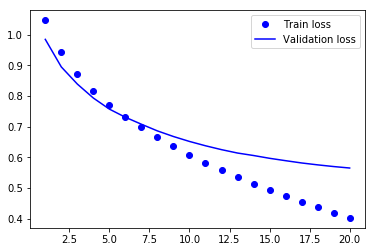

In [85]:
eval_metric(emb_history, 'loss')

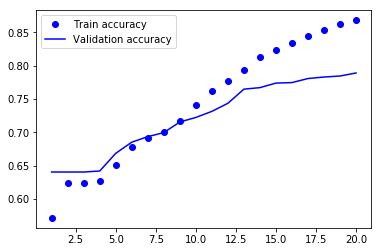

In [86]:
eval_metric(emb_history, 'accuracy')

In [87]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1464/1464 [==============================] - 0s 172us/step
/n
Test accuracy of word embeddings model: 79.51%


In [88]:
#glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(r'C:\Users\HPPC\glove.twitter.27B.50d.txt',encoding = 'utf-8')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [125]:
emb_dict['airplane']

array([-0.81025  ,  0.065925 ,  0.037334 ,  0.20972  , -1.0245   ,
        0.12996  ,  0.89665  , -0.89213  ,  0.90432  , -0.17672  ,
        0.10469  , -0.059729 , -2.1969   ,  0.045489 ,  0.55135  ,
        0.037913 , -0.16072  , -0.23501  ,  0.10547  ,  0.036028 ,
       -0.1099   , -0.54038  ,  0.53394  , -0.47578  , -0.29356  ,
        0.67219  , -1.2894   , -0.01972  , -0.24386  ,  0.35355  ,
       -0.22151  ,  0.099795 ,  0.41025  , -1.2657   ,  0.67407  ,
        0.8334   ,  0.48999  ,  0.12838  ,  0.68459  , -0.31924  ,
        0.40274  ,  0.74228  , -0.71629  , -0.98246  ,  0.25153  ,
        0.90011  , -0.26397  ,  0.30161  ,  0.0097203,  1.3439   ],
      dtype=float32)

In [89]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


In [90]:
emb_matrix = np.zeros((NB_WORDS, 50))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [91]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 24, 50)            500000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3603      
Total params: 503,603
Trainable params: 503,603
Non-trainable params: 0
_________________________________________________________________


In [92]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [127]:
glove_model.layers[0]

In [93]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 1s 118us/step - loss: 0.8336 - accuracy: 0.6435 - val_loss: 0.7464 - val_accuracy: 0.7033
Epoch 2/20
11858/11858 [==============================] - 1s 76us/step - loss: 0.7257 - accuracy: 0.7053 - val_loss: 0.6936 - val_accuracy: 0.7269
Epoch 3/20
11858/11858 [==============================] - 1s 67us/step - loss: 0.6748 - accuracy: 0.7329 - val_loss: 0.6614 - val_accuracy: 0.7360
Epoch 4/20
11858/11858 [==============================] - 1s 71us/step - loss: 0.6422 - accuracy: 0.7471 - val_loss: 0.6424 - val_accuracy: 0.7451
Epoch 5/20
11858/11858 [==============================] - 1s 70us/step - loss: 0.6206 - accuracy: 0.7538 - val_loss: 0.6279 - val_accuracy: 0.7534
Epoch 6/20
11858/11858 [==============================] - 1s 62us/step - loss: 0.6044 - accuracy: 0.7601 - val_loss: 0.6182 - val_accuracy: 0.7564
Epoch 7/20
11858/11858 [==============================] - 1s 75us/st

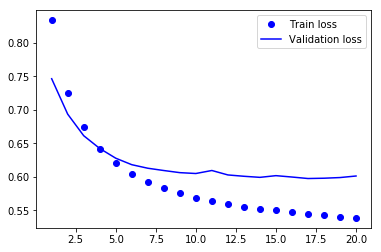

In [94]:
eval_metric(glove_history, 'loss')

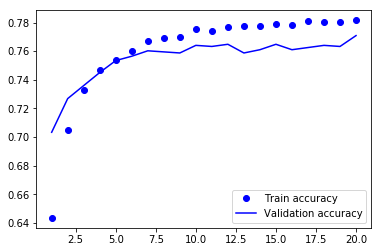

In [95]:
eval_metric(glove_history, 'accuracy')

In [96]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))


1464/1464 [==============================] - 0s 210us/step
/n
Test accuracy of word glove model: 76.23%


In [97]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(3, activation='softmax'))
emb_model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 24, 50)            500000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3603      
Total params: 503,603
Trainable params: 503,603
Non-trainable params: 0
_________________________________________________________________


In [98]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 3s 265us/step - loss: 0.9429 - accuracy: 0.6208 - val_loss: 0.8481 - val_accuracy: 0.6404
Epoch 2/20
11858/11858 [==============================] - 2s 202us/step - loss: 0.8111 - accuracy: 0.6359 - val_loss: 0.7644 - val_accuracy: 0.6540
Epoch 3/20
11858/11858 [==============================] - 3s 212us/step - loss: 0.7237 - accuracy: 0.6749 - val_loss: 0.7105 - val_accuracy: 0.7041
Epoch 4/20
11858/11858 [==============================] - 2s 189us/step - loss: 0.6457 - accuracy: 0.7287 - val_loss: 0.6566 - val_accuracy: 0.7238
Epoch 5/20
11858/11858 [==============================] - 4s 295us/step - loss: 0.5742 - accuracy: 0.7791 - val_loss: 0.6193 - val_accuracy: 0.7451
Epoch 6/20
11858/11858 [==============================] - 4s 296us/step - loss: 0.5121 - accuracy: 0.8168 - val_loss: 0.5898 - val_accuracy: 0.7777
Epoch 7/20
11858/11858 [==============================] - 3s 23

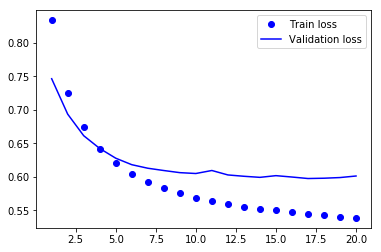

In [99]:
eval_metric(glove_history, 'loss')

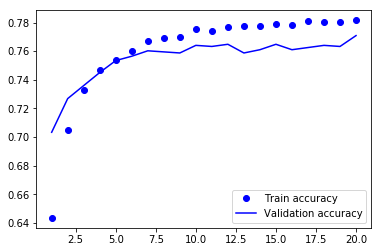

In [100]:
eval_metric(glove_history, 'accuracy')

In [101]:
emb_results2 = test_model(emb_model2, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word embedding model 2: {0:.2f}%'.format(emb_results2[1]*100))

1464/1464 [==============================] - ETA: 0s - 0s 247us/step
/n
Test accuracy of word embedding model 2: 79.78%


In [145]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
#from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

In [146]:
# Read file into dataframe
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv(r'C:\Users\HPPC\Tweets.csv',encoding = 'utf-8')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8105,568785094430883840,positive,1.0000,NaN,NaN,Delta,NaN,AlanaMYzola,NaN,0,@JetBlue great flight! Great view! :-) http://t.co/Yxn00pnOav,NaN,2015-02-20 06:51:48 -0800,NaN,NaN
10025,569566323912671232,neutral,0.6402,NaN,0.0000,US Airways,NaN,helmsdanielle10,NaN,0,@USAirways Look into better service.,NaN,2015-02-22 10:36:08 -0800,NaN,NaN
12085,570297070998974464,positive,0.6497,NaN,0.0000,American,NaN,rakugojon,NaN,0,@AmericanAir got back eventually! Was a rollercoaster. Once I got to the airport &amp; got to speak to someone things got fixed very quick.,NaN,2015-02-24 10:59:51 -0800,San Francisco,London
9906,569621412325023744,negative,1.0000,Customer Service Issue,0.6889,US Airways,NaN,OutsideHitter84,NaN,0,@USAirways I left an item on plane BOS-PHL on Friday. I've called PHL US Airways # &amp; left 6 msgs. No return call what to do at this point.,NaN,2015-02-22 14:15:02 -0800,NaN,NaN
14001,569678905344270336,positive,1.0000,NaN,NaN,American,NaN,stf_tsm,NaN,0,Thank you for sending more details @AmericanAir: They're pretty handy dandy. more info here: http://t.co/FvlxIRh1F1 #LookforwardtoflywithAA,NaN,2015-02-22 18:03:29 -0800,NaN,NaN


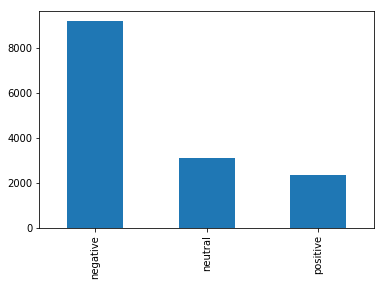

In [147]:
df['airline_sentiment'].value_counts().plot(kind='bar')

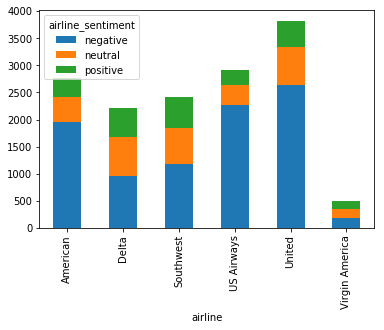

In [148]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

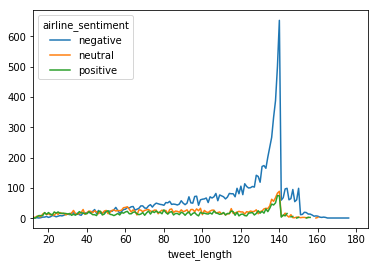

In [149]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

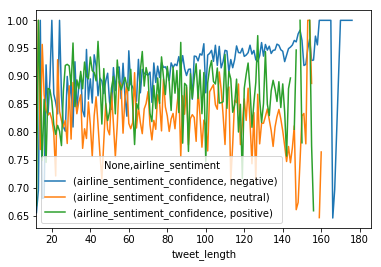

In [150]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)

In [151]:
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [152]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

NameError: name 'TextClasDataBunch' is not defined

In [ ]:
!conda create -n env_pytorch python=3.6


In [ ]:
source activate env_pytorch

In [ ]:
!pip install torchvision --user

In [ ]:
import torch
import torchvision

In [ ]:
from fastai.text import *